In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import torch
import tqdm

sys.path.append(os.path.dirname(os.getcwd())) 
from source.model_output import SEIRModelOutput, SEIRParams
from source.SEIR_network import SEIRNetworkModel
from source.autoencoder import AESurrogateModel
from source.forecast import SEIRForecaster
import source.plots as plots

from sklearn.metrics import r2_score

# to account for updates when files change
%load_ext autoreload
%autoreload 2

In [2]:
ae_model = AESurrogateModel(population=10**5)

beta = 0.5 # transmission rate
gamma = 0.3 # latent period rate
delta = 0.2 # recovery rate
init_inf_frac = 1e-4 # fraction of initially infected

alpha = 0.95
beta = 0.1

initial_params = SEIRParams(0.5, 0.5, gamma, delta, init_inf_frac, tmax=150)
observed_incidence = np.loadtxt('../data/incidence_synthetic_curve.csv'
                               )[:100]
simulation_incidence = ae_model.simulate(alpha, beta, gamma, delta, init_inf_frac)

In [3]:
observed_data = pd.read_csv('../data/incidence_synthetic_curve.csv'
                           ).iloc[:100]
observed_data.columns=['incidence']
peak_index = observed_data.incidence.argmax()
observed_data.iloc[:peak_index - 14].shape

(13, 1)

In [22]:
observed_data = pd.read_csv('../data/incidence_synthetic_curve.csv'
                           ).iloc[:100]
observed_data.columns=['incidence']
observed_incidence = observed_data.incidence.values
observed_incidence

array([  77,  133,  209,  248,  316,  362,  407,  457,  543,  662,  746,
        905, 1008, 1162, 1305, 1456, 1597, 1838, 1990, 2151, 2341, 2509,
       2590, 2879, 2893, 2862, 2873, 2928, 2898, 2743, 2731, 2632, 2440,
       2351, 2077, 1873, 1787, 1634, 1545, 1369, 1265, 1121,  966,  902,
        730,  772,  604,  615,  494,  463,  400,  354,  296,  283,  240,
        231,  178,  186,  147,  123,  134,   84,   89,  101,   60,   52,
         55,   48,   32,   30,   42,   22,   19,   14,   14,   15,   13,
          6,    6,    7,    5,    5,    7,    3,    6,    5,    3,    5,
          0,    2,    2,    0,    0,    1,    3,    1,    2,    1,    0,
          1])

In [23]:

peak_index = observed_incidence.argmax()
onset_period = peak_index - 14 
peak_period = peak_index - 7
end_period = peak_index + 7
peak_index, onset_period, peak_period, end_period

(np.int64(27), np.int64(13), np.int64(20), np.int64(34))

In [24]:
%%time

peak_index = observed_incidence.argmax()

onset_period = peak_index - 14
peak_period = peak_index - 7
end_period = peak_index + 7

for period in [onset_period, peak_period, end_period]:
    forecaster = SEIRForecaster(initial_params=initial_params)

    idata_onset = forecaster.calibrate(ae_model, 
                                             observed_incidence[:100],
                                             period,
                                             epsilon=500)

    idata_onset.sample_stats['beta'] = idata_onset.sample_stats['beta'].astype(str)
    idata_onset.to_netcdf(f"ba_surr_a{alpha}_b{beta}_from_{period}n.nc")


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

CPU times: total: 8.73 s
Wall time: 1min 38s


In [6]:
file='../data/ba-network-100k_dataset.csv'
d = pd.read_csv(file, index_col=0)#.iloc[::10]

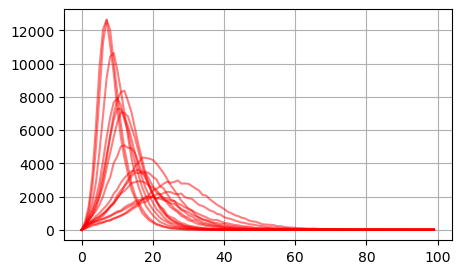

In [7]:
plt.subplots(figsize=(5,3))

file='../data/ba-network-100k_dataset.csv'
d = pd.read_csv(file, index_col=0)#.iloc[::10]
if 'init_rec_frac' in d.columns:
    d.rename(columns={'init_rec_frac':'alpha'}, inplace=True)
d.drop(columns=['gamma','delta','init_inf_frac'], inplace=True)
d.columns = ['beta','alpha', *np.arange(150)]

d.alpha = d.alpha.round(2)
d.beta = d.beta.round(2)


for a,b in zip([0.95, 0.97,0.85, 0.97, 0.88,
               0.75,.65,.74, .65, .97, .85, .74,   
                .98, .85, .7, .61],
               [0.1, 0.5,0.95,0.95,0.5,
               0.95, .95,.5, .49, .3,.3,.3,     
                .75, .75, .75, .75]):
    observed_data = d[(d.beta==b)&(d.alpha==a)].iloc[0,2:102]
    observed_data.columns=['incidence']
    plt.plot(observed_data, color='red', alpha=.5)

plt.grid()

In [9]:
for a,b in tqdm.tqdm(zip([0.95, 0.97,0.85, 0.97, 0.88,
               0.75,.65,.74, .65, .97, .85, .74,   
                .98, .85, .7, .61],
               [0.1, 0.5,0.95,0.95,0.5,
               0.95, .95,.5, .49, .3,.3,.3,     
                .75, .75, .75, .75])):
    observed_incidence = d[(d.beta==b)&(d.alpha==a)
                          ].iloc[0,2:102].values
    
    forecaster = SEIRForecaster(initial_params=initial_params)

    idata_onset = forecaster.calibrate(ae_model, 
                                             observed_incidence[:100],
                                             len(observed_incidence),
                                             epsilon=2000)

    idata_onset.sample_stats['beta'] = idata_onset.sample_stats['beta'].astype(str)
    idata_onset.to_netcdf(f"ba_surr_a{a}_b{b}_full_n.nc")

0it [00:00, ?it/s]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


1it [00:27, 27.08s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


2it [00:51, 25.25s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


3it [01:16, 25.37s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


4it [01:39, 24.47s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


5it [02:04, 24.67s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


6it [02:24, 22.92s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


7it [02:44, 21.91s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


8it [03:05, 21.63s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


9it [03:27, 21.84s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


10it [03:54, 23.57s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


11it [04:22, 24.90s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


12it [04:44, 23.81s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


13it [05:07, 23.73s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


14it [05:33, 24.30s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


15it [05:54, 23.38s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


C:\Users\user\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


16it [06:14, 23.40s/it]


In [62]:
idata_onset

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [ ]:
for period in [onset_period, peak_period, end_period]:
    forecaster = SEIRForecaster(initial_params=initial_params)

    idata_onset = forecaster_onset.calibrate(ae_model, 
                                             observed_incidence[:100],
                                             period,
                                             epsilon=500)

    idata_onset.sample_stats['beta'] = idata_onset.sample_stats['beta'].astype(str)
    idata_onset.to_netcdf(f"ba_surr_a{alpha}_b{beta}_full.nc")

In [33]:
idata_onset

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

KeyError: 'var names: "[\'beta\'] are not present" in dataset'

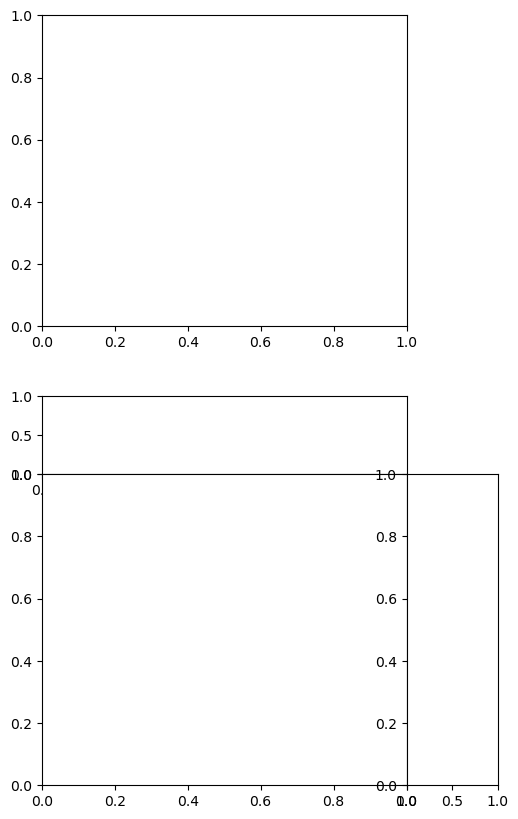

In [16]:
true_alpha = 0.95
true_beta = 0.1
fig = plots.plot_calib_subplots([idata_onset, idata_onset, idata_onset], 
              [observed_incidence[:end] for end in [onset_period, 
                                                    onset_period, 
                                                    onset_period]], 
              true_params_dict={'alpha': true_alpha, 
                                'beta': true_beta},
              full_data=observed_incidence
                               )
#fig.savefig('../figures/ae_ba_network_hdr_subplots.pdf', bbox_inches='tight')
#fig.savefig('../figures/ae_ba_network_hdr_abc_subplots.png', bbox_inches='tight', dpi=600)


In [6]:
fig = create_plots_grid_forecast(array_of_params_dict=[params_dict_onset, params_dict_peak, params_dict_end], 
                           array_of_observed=[observed_incidence[:onset_period], 
                                                       observed_incidence[:peak_period],
                                                       observed_incidence[:end_period]],
                           full_data=observed_incidence)
#fig.savefig('../figures/ae_ba_network_forercast.pdf', bbox_inches='tight')
#fig.savefig('../figures/ae_ba_network_forercast.png', dpi=600, bbox_inches='tight')

NameError: name 'create_plots_grid_forecast' is not defined